In [50]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import plotly.express as px
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [4]:
listening_history = pd.read_csv('../data/listening_history.csv', sep='\t')
id_information = pd.read_csv('../data/id_information.csv', sep='\t')
id_tags = pd.read_csv('../data/id_tags.csv', sep='\t')
id_genres = pd.read_csv('../data/id_genres.csv', sep='\t')
id_metadata = pd.read_csv('../data/id_metadata.csv', sep='\t')
id_lang = pd.read_csv('../data/id_lang.csv', sep='\t')

In [5]:
listening_history.head()

,user,song,timestamp
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09


In [6]:
id_information.head()

,id,artist,song,album_name
0,0009fFIM1eYThaPg,Cheryl,Rain on Me,3 Words
1,0010xmHR6UICBOYT,Oddisee,After Thoughts,The Beauty in All
2,002Jyd0vN4HyCpqL,Blue Öyster Cult,ME 262,Secret Treaties
3,006TYKNjNxWjfKjy,Rhapsody,Flames of Revenge,Legendary Years (Re-Recorded)
4,007LIJOPQ4Sb98qV,The Chameleons,Nostalgia,What Does Anything Mean? Basically (2009 Remas...


In [7]:
id_tags.head()

,id,tags
0,0009fFIM1eYThaPg,"pop,british,female vocalists,dance,cheryl cole"
1,0010xmHR6UICBOYT,"instrumental hip-hop,underground hip hop,instr..."
2,002Jyd0vN4HyCpqL,"hard rock,rock,classic rock,american artist"
3,006TYKNjNxWjfKjy,"symphonic metal,power metal,symphonic power metal"
4,007LIJOPQ4Sb98qV,"post-punk,new wave,1985"


In [8]:
id_genres.head()

,id,genres
0,0009fFIM1eYThaPg,pop
1,0010xmHR6UICBOYT,underground hip hop
2,002Jyd0vN4HyCpqL,"hard rock,rock,classic rock"
3,006TYKNjNxWjfKjy,"symphonic metal,power metal,symphonic power metal"
4,007LIJOPQ4Sb98qV,"post-punk,new wave"


In [9]:
id_metadata.head()

,id,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
0,0009fFIM1eYThaPg,3eObKIfHKJ1nAPh0wTxFCc,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947
1,0010xmHR6UICBOYT,27szvF97Tu95GxN98N52fy,46.0,2013,0.591,0.513,7.0,0.0,0.263,172.208,325096
2,002Jyd0vN4HyCpqL,273lBFpxUCwisTpdnF9cVb,31.0,1974,0.319,0.925,2.0,1.0,0.658,157.630,285693
3,006TYKNjNxWjfKjy,1qZgergQ41vaD4zBf3AKXR,33.0,2017,0.432,0.979,7.0,1.0,0.162,90.008,332867
4,007LIJOPQ4Sb98qV,6rVxJ3sN3Cz40MSLavbG1K,19.0,2009,0.357,0.708,9.0,1.0,0.470,123.904,326067


In [10]:
id_lang.head()

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en


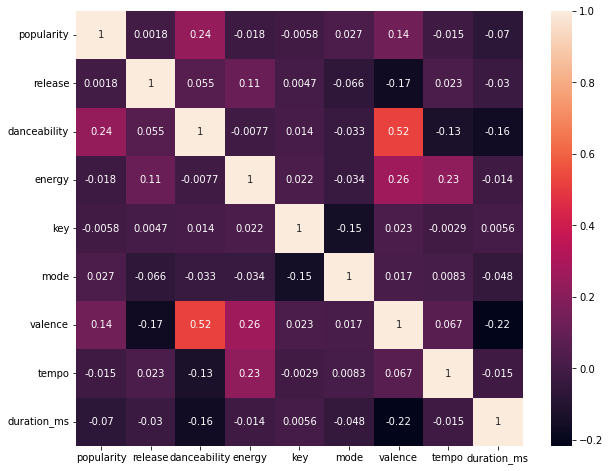

In [53]:
plt.figure(figsize=(10, 8)) 
ax = sns.heatmap(id_metadata.corr(), annot=True)
plt.show()

# Data transformation

In [11]:
# full_song_info = pd.DataFrame(listening_history.song.dropna().unique(), columns=['song'])
full_song_info = listening_history.copy()
full_song_info.rename(columns = {'song':'id'}, inplace = True)
full_song_info

,user,id,timestamp
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09
...,...,...,...
5109587,user_zzWscYTy,BBiswLufo26YQCT7,2019-01-10 15:57
5109588,user_zzWscYTy,5ZHgff3sjETIiedr,2019-01-10 16:21
5109589,user_zzWscYTy,m4O1iLh6fC43xjRy,2019-01-10 16:48
5109590,user_zzWscYTy,mvUaP8k67qOFfA65,2019-01-10 21:13


In [12]:
full_song_info = pd.merge(full_song_info, id_information, on=['id'])
full_song_info = pd.merge(full_song_info, id_tags, on=['id'])
full_song_info = pd.merge(full_song_info, id_genres, on=['id'])
full_song_info = pd.merge(full_song_info, id_metadata, on=['id'])
full_song_info = pd.merge(full_song_info, id_lang, on=['id'])
full_song_info

,user,id,timestamp,artist,song,album_name,tags,genres,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms,lang
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.130,76.972,212184,en
1,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-26 18:09,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.130,76.972,212184,en
2,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 13:32,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.130,76.972,212184,en
3,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 13:50,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.130,76.972,212184,en
4,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 19:35,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.130,76.972,212184,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109587,user_zvN2NV5F,f5NTrCtvRA6b0n4L,2019-02-07 01:56,Lynyrd Skynyrd,Down South Jukin',Skynyrd's First: The Complete Muscle Shoals Album,"southern rock,classic rock,rock,supernatural","southern rock,classic rock,rock",4cV7R9NTRqL6equhYdehYL,41.0,1998,0.620,0.786,8.0,1.0,0.923,131.447,134800,en
5109588,user_zvqqjDEW,Cse4wkzig03ZT86e,2019-01-19 23:07,The Sins of Thy Beloved,My Love,Lake of Sorrow,"doom metal,symphonic metal,gothic metal,gothic...","doom metal,symphonic metal,gothic metal",6SXLWCqXPidiVtTaFBbOVB,8.0,1998,0.286,0.753,2.0,1.0,0.195,124.372,570680,en
5109589,user_zwYyH93G,hKWwaAkkIuaEYqO5,2019-03-07 22:59,Jennifer Lopez,Talk About Us,On The 6,"pop,latin,90s,female vocalists","pop,latin",5DQvUFEmMu4CSbmEnkCmio,25.0,1999,0.705,0.536,6.0,1.0,0.252,80.988,274467,en
5109590,user_zwjkkiDG,u6tON1C2GLRiCalC,2019-02-20 17:46,Johnossi,Air Is Free,Blood Jungle,"swedish,indie rock,indie,rock,alternative","indie rock,rock",1xiSJNdlIcV4Wkw0htbpMt,43.0,2017,0.385,0.893,5.0,1.0,0.484,173.784,221293,en


## Calculate user-level statistics

In [13]:
user_stats = full_song_info.groupby("user").agg(
    total_songs_listened=pd.NamedAgg(column="id", aggfunc="count"),
    average_popularity=pd.NamedAgg(column="popularity", aggfunc="mean"),
    average_release=pd.NamedAgg(column="release", aggfunc="mean"),
    average_danceability=pd.NamedAgg(column="danceability", aggfunc="mean"),
    average_energy=pd.NamedAgg(column="energy", aggfunc="mean"),
    average_key=pd.NamedAgg(column="key", aggfunc="mean"),
    average_mode=pd.NamedAgg(column="mode", aggfunc="mean"),
    average_valence=pd.NamedAgg(column="valence", aggfunc="mean"),
    average_tempo=pd.NamedAgg(column="tempo", aggfunc="mean"),
    average_duration_ms=pd.NamedAgg(column="duration_ms", aggfunc="mean"),
).reset_index()
user_stats

,user,total_songs_listened,average_popularity,average_release,average_danceability,average_energy,average_key,average_mode,average_valence,average_tempo,average_duration_ms
0,user_007XIjOr,440,33.613636,2008.475000,0.515984,0.480951,5.038636,0.593182,0.354996,116.065541,250081.668182
1,user_00Y0Uqn9,399,52.027569,2017.172932,0.608080,0.576617,5.426065,0.496241,0.383022,114.106799,216408.295739
2,user_00c8xHqc,391,60.861893,2012.772379,0.630724,0.494363,5.869565,0.624041,0.500182,111.171309,212700.488491
3,user_00qujrxB,403,42.091811,2012.689826,0.497762,0.654020,4.982630,0.727047,0.359684,123.543027,249989.818859
4,user_00s56GJz,386,37.036269,2015.422280,0.484655,0.724961,5.782383,0.367876,0.326981,120.166964,277516.261658
...,...,...,...,...,...,...,...,...,...,...,...
14122,user_zyDTgcHV,306,53.160131,2009.209150,0.639284,0.574677,4.895425,0.545752,0.546204,117.801797,202791.823529
14123,user_zzCNtMQy,396,67.608586,2015.123737,0.645313,0.640129,5.401515,0.512626,0.484045,118.831217,213057.588384
14124,user_zzIyYHRx,404,48.992574,2012.150990,0.658698,0.599221,5.101485,0.465347,0.536164,123.892663,214280.960396
14125,user_zzU2bfEp,398,41.173367,2007.324121,0.566711,0.743884,5.351759,0.623116,0.509552,125.545314,242478.459799


In [41]:
# Select the first 100 unique user IDs
selected_users = full_song_info['user'].unique()[:100]

# Filter the DataFrame to include only data from the selected users
selected_users_song_info = full_song_info[full_song_info['user'].isin(selected_users)]
selected_users_song_info


,user,id,timestamp,artist,song,album_name,tags,genres,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms,lang
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.1300,76.972,212184,en
1,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-26 18:09,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.1300,76.972,212184,en
2,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 13:32,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.1300,76.972,212184,en
3,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 13:50,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.1300,76.972,212184,en
4,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 19:35,Mitski,Your Best American Girl,Puberty 2,"2016,somafm,bagel,indie rock,noise pop,indie r...","indie rock,noise pop,indie rock,dream pop",172rW45GEnGoJUuWfm1drt,55.0,2016,0.360,0.257,7.0,1.0,0.1300,76.972,212184,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053326,user_P61S2VZM,KxuSbIvccgwkosWa,2019-02-23 12:02,The Prodigy,Firestarter - Live,World's on Fire (Live),"electronic,techno,industrial,dance,electronic,...","electronic,techno,industrial,electronic,techno...",5LYuMZITPYtzSYE77fm1sd,26.0,2011,0.438,0.969,11.0,0.0,0.3160,141.532,279867,en
5053327,user_P61S2VZM,KxuSbIvccgwkosWa,2019-03-01 20:02,The Prodigy,Firestarter - Live,World's on Fire (Live),"electronic,techno,industrial,dance,electronic,...","electronic,techno,industrial,electronic,techno...",5LYuMZITPYtzSYE77fm1sd,26.0,2011,0.438,0.969,11.0,0.0,0.3160,141.532,279867,en
5053328,user_P61S2VZM,uusMHJPXqZgBEg6W,2019-01-30 14:04,Rival Consoles,Howl,Howl,"idm,electronic,ambient,2015,experimental,idm,e...","electronic,ambient,experimental,electronic,amb...",3dbNYSYgBeL4faBSJfyVVh,40.0,2015,0.616,0.707,4.0,0.0,0.0550,100.991,269611,INTRUMENTAL
5053333,user_P61S2VZM,sDSnjyax8ttPZvHr,2019-02-27 09:19,Tim Maia,Nossa História De Amor,Tim Maia 1980,"brasil,80s,mpb,pop nacional,tim maia,funk naci...","mpb,pop nacional",1ydbpdhB8QBgM5j0loXxSL,20.0,1980,0.642,0.693,5.0,1.0,0.7470,100.554,264122,pt


In [49]:
selected_users_features = selected_users_song_info.copy()
selected_users_features = selected_users_features.drop(columns=['timestamp', 'artist', 'song', 'album_name', 'tags', 'genres', 'spotify_id', 'tempo','release', 'duration_ms', 'lang'])
selected_users_features

,user,id,popularity,danceability,energy,key,mode,valence
0,user_007XIjOr,DaTQ53TUmfP93FSr,55.0,0.360,0.257,7.0,1.0,0.1300
1,user_007XIjOr,DaTQ53TUmfP93FSr,55.0,0.360,0.257,7.0,1.0,0.1300
2,user_02DWuQOR,DaTQ53TUmfP93FSr,55.0,0.360,0.257,7.0,1.0,0.1300
3,user_02DWuQOR,DaTQ53TUmfP93FSr,55.0,0.360,0.257,7.0,1.0,0.1300
4,user_02DWuQOR,DaTQ53TUmfP93FSr,55.0,0.360,0.257,7.0,1.0,0.1300
...,...,...,...,...,...,...,...,...
5053326,user_P61S2VZM,KxuSbIvccgwkosWa,26.0,0.438,0.969,11.0,0.0,0.3160
5053327,user_P61S2VZM,KxuSbIvccgwkosWa,26.0,0.438,0.969,11.0,0.0,0.3160
5053328,user_P61S2VZM,uusMHJPXqZgBEg6W,40.0,0.616,0.707,4.0,0.0,0.0550
5053333,user_P61S2VZM,sDSnjyax8ttPZvHr,20.0,0.642,0.693,5.0,1.0,0.7470


In [16]:
# Create a user-song interaction matrix (binary) where rows are users and columns are songs
user_song_matrix = pd.crosstab(full_song_info['user'], full_song_info['id'], values=1, aggfunc='sum')
user_song_matrix

id,0009fFIM1eYThaPg,0010xmHR6UICBOYT,002Jyd0vN4HyCpqL,006TYKNjNxWjfKjy,007LIJOPQ4Sb98qV,00CH4HJdxQQQbJfu,00DZ3XCAQb2FdCc6,00GCd9HYEge6Ntwi,00IeldeA9ijZOL0P,00KSCJkYb8JKa4Y3,...,zzoFYDMlqU1X2zz1,zzp2MNG0xjWs7NiN,zzpkRCGA5ud8q4mv,zzqNN6leHep4q1K7,zzx8CWdM7qkxKQpC,zzyb5LvKJTWLVnrk,zzyyPUs7hC9Nz2e1,zzz0n04uuTUA7fNh,zzznMjZAKnJJXQSj,zzzwh2ktIWjsR7xp
user,,,,,,,,,,,,,,,,,,,,,
user_007XIjOr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_00Y0Uqn9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_00c8xHqc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_00qujrxB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_00s56GJz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user_zyDTgcHV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_zzCNtMQy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_zzIyYHRx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Define sequence length (number of songs in a user's listening history)
sequence_length = 50  # Adjust as needed

# Prepare sequences of songs for training
sequences = []
next_songs = []

# Iterate through users to create sequences and next_songs
for user_index, user_row in user_song_matrix.iterrows():
    song_ids = user_row[user_row.notnull()].index.tolist()
    if len(song_ids) >= sequence_length + 1:
        for i in range(len(song_ids) - sequence_length):
            sequences.append(song_ids[i:i+sequence_length])
            next_songs.append(song_ids[i+sequence_length])



In [32]:
song_ids

['04iQE4VyxOcloEVY',
 '0XwFJfmuYnVo7cYq',
 '0dnPjIfjqpFLPYIl',
 '13avOnDUqkbSzRyI',
 '1gusFNVjSLQ0NFzY',
 '2Dh5BEwlWqiQmNtN',
 '2MQd91oVzftaQOHI',
 '2ZNfLjY3qKdM6kAP',
 '3Y5qu2SYcGIi0hk8',
 '4Du2pRRQRaOyKBTG',
 '4R1LOOq2sAnvmUhS',
 '4Wb6mkYeW0XuiUet',
 '4cs3JsHc4XXOOStS',
 '4lPXNeHE21gQSYMM',
 '5W7RTSzYz8EVHroD',
 '5ZHgff3sjETIiedr',
 '5utAtxO4Uvjv63gZ',
 '62JzqGi7XyO8pvUZ',
 '6q82iduttMTsOFW9',
 '7mjA9pJ32t2pVUgy',
 '7v1UlutClEneqBUO',
 '81ASaljkwQQcPAsA',
 '8L0NYoham5YHm3XF',
 '9QsB89mcLB2yFgs3',
 'A2USCXRSRzQOBEYN',
 'Awwf1OBE6Q6vbyum',
 'BBiswLufo26YQCT7',
 'BG2jkENMRTQZ3XNJ',
 'BNYuTkqVOXsWRtry',
 'BzafUVzJXOb49I0g',
 'CDoeNVd3S29QHnpG',
 'CTB8ewr815LhFQHe',
 'DVwgW5nghZigU5KR',
 'DY3McyB5q2XNs2VZ',
 'DmP1tq2MdBzneMfr',
 'Em91uCHG0ehWyhx9',
 'EmPJO7fTwQlTDjGG',
 'EzMAbcZadxwEBlsR',
 'F7vUjfbLv2Xoc3rT',
 'FF0pi5UX2XCptetA',
 'FO5snzz2ZG9XtPxL',
 'FfAOWFUOWdSn0M08',
 'FgVHr6Ute9QT3YP5',
 'G8ueEOh6T3ep0kTa',
 'G9B6eX6VdJQuSy9Y',
 'GAjjAPjh4tuSJ2jM',
 'GpQNCV6xUkKYczKr',
 'HBICwtlrNOP

In [31]:
sequences

array([['019Q5nZ079pL34qa', '0247XD85scrr19o0', '04iQE4VyxOcloEVY', ...,
        'FtnuMT1DlevSR2n5', 'GWPGKg6iJcTs6iu0', 'Gof4MUngidge7y1f'],
       ['0247XD85scrr19o0', '04iQE4VyxOcloEVY', '0K3SrhMknjp3HCQg', ...,
        'GWPGKg6iJcTs6iu0', 'Gof4MUngidge7y1f', 'GsahgqMVYOoiWdue'],
       ['04iQE4VyxOcloEVY', '0K3SrhMknjp3HCQg', '0MlouT1rCMQlu1Ps', ...,
        'Gof4MUngidge7y1f', 'GsahgqMVYOoiWdue', 'HIOztkPb4YCd1U6p'],
       ...,
       ['kQjIDTHlGMfDbYTF', 'lEUXl1hlqjN7xEKf', 'lMD1vFauqRVuBXQQ', ...,
        'y15PxmDsr87Ul3AB', 'y5iI2R8d4Zv1VCPs', 'yUQa4ZdWaVhpH3DJ'],
       ['lEUXl1hlqjN7xEKf', 'lMD1vFauqRVuBXQQ', 'lbq1A6sWhP4HcLvq', ...,
        'y5iI2R8d4Zv1VCPs', 'yUQa4ZdWaVhpH3DJ', 'yfm7RER1PWTqgjIp'],
       ['lMD1vFauqRVuBXQQ', 'lbq1A6sWhP4HcLvq', 'lcUEwqcqB0tnw3YA', ...,
        'yUQa4ZdWaVhpH3DJ', 'yfm7RER1PWTqgjIp', 'z7gqPfuaCyCR9Myt']],
      dtype='<U16')

In [30]:
next_songs

array(['GsahgqMVYOoiWdue', 'HIOztkPb4YCd1U6p', 'HoJktTVZrsaESEcq', ...,
       'yfm7RER1PWTqgjIp', 'z7gqPfuaCyCR9Myt', 'zkJb2QRrowAMNqvr'],
      dtype='<U16')

In [20]:
# Convert sequences and next_songs to numpy arrays
sequences = np.array(sequences)
next_songs = np.array(next_songs)

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, next_songs, test_size=0.2, random_state=42)

In [33]:
# Assuming you have X_train and y_train as your training data
# X_train: sequences of songs, y_train: corresponding next songs

# Define the maximum number of unique songs and the sequence length
num_unique_songs = np.max([np.max(X_train), np.max(y_train)]) + 1
sequence_length = X_train.shape[1]

# Create a sequential model
model = Sequential()

# Add an embedding layer to map song IDs to dense vectors
model.add(Embedding(input_dim=num_unique_songs, output_dim=50, input_length=sequence_length))

# Add an LSTM layer to capture sequential patterns in the data
model.add(LSTM(100))  # Adjust the number of LSTM units as needed

# Add a dense output layer to predict the next song
model.add(Dense(num_unique_songs, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

UFuncTypeError: ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U16'), dtype('<U16')) -> None